# making a new transformer class

- countvectorize category column to make separate into separate individual categories
- multiply price by category
- "standard scale" it
    - take average of category to get average price
    - see whether an individual listing or group of listings is disproportionately high or low
- feature engineer price * ratings? or ratings * category?

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import FeatureUnion, Pipeline

In [20]:
data = pd.read_csv('../data/03_data_income.csv')
data.head()

,id,latitude,longitude,price,review_count,rating,zip_code,city,alias,category,med_agi,avg_agi,count
0,zzvkb4J_sQAk8N20OWdZhg,33.911154,-117.881259,2,1257.0,3.5,92821,Brea,lucilles-smokehouse-bar-b-que-brea,"['bbq', 'smokehouse', 'southern']",86070,106163,170
1,zWs68lBY2PyNOTRJhxXapg,33.911959,-117.867374,1,22.0,3.0,92821,Brea,subway-restaurants-brea-4,['sandwiches'],86070,106163,170
2,zOYNwoDjpg6Ehwn0RKX9qA,33.911283,-117.867449,2,367.0,3.5,92821,Brea,nekter-juice-bar-brea,"['juicebars', 'acaibowls', 'icecream']",86070,106163,170
3,zNNLl821AlzApHYqRxNALw,33.911431,-117.865941,1,84.0,2.5,92821,Brea,arbys-brea-2,"['sandwiches', 'hotdogs']",86070,106163,170
4,zJ4pvxtpo3Y5LvylLXmCzA,33.932860,-117.916253,2,231.0,4.0,92821,Brea,portofino-trattoria-brea,['italian'],86070,106163,170


In [21]:
data.shape

(28112, 13)

In [22]:
X = data.drop(columns=['avg_agi', 'med_agi'])
y_avg = data['avg_agi']
y_med = data['med_agi']

In [34]:
# https://stackoverflow.com/questions/46778392/
# https://stackoverflow.com/questions/34734940/

'''
use function for both X_train and X_test
you can save as a different DF or overwrite

maybe this can go in a markdown cell:

    We first use CountVectorizer() to create dummy columns for
    each category. We multiply these columns the price by the 
    dummy categories so that we can get a price inside the
    category column.
    
    e.g. if a Korean restaurant has a price of '3', then we 
    want that row to have a '3' in the 'korean' column.
    
    This allows us to standard scale each category column so
    that we can assess the relative price of each business
    listing given its category. That way, if one area has
    relatively expensive Korean restaurants, and another area
    has relatively inexpensive jewelry stores, those scaled
    factors may have an effect in our ability to model.
    
'''

def category_pricer(X, y, state=42):
    '''
    Adds scaled price columns to a Yelp Business DataFrame.
    
    Arguments:
        X:              dataframe containing all features
        y:              array containing all targets
        state:          random state of train_test_split()
                                    
    Returns:
        X_train, X_test, y_train, y_test
        X_train and X_test contain two new columns:
        'price_sc':     scaled price
        'adj_price':    mean of category-scaled prices

    Goal:   to standard scale the price of a business listing
            given its category.
    '''
    X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    random_state=state)    
    
    # instantiate CountVectorizer() and fit 'category'
    cvect = CountVectorizer()

    # fit_transform train data
    c_train = cvect.fit_transform(X_train['category']).toarray()
    for i in range(len(c_train)):
        c_train[i] = c_train[i] * X_train['price'].values[i]
    cat_train = cvect.get_feature_names()
    C_train = pd.DataFrame(c_train, columns=cat_train)
    C_train.replace(0, np.NaN, inplace=True)
    
    # only transform test data
    c_test = cvect.transform(X_test['category']).toarray()
    for j in range(len(c_test)):
        c_test[j] = c_test[j] * X_test['price'].values[j]
    cat_test = cvect.get_feature_names()
    C_test = pd.DataFrame(c_test, columns=cat_test)
    C_test.replace(0, np.NaN, inplace=True)
    
    # standard scale each category
    sc = StandardScaler()
    S_train = pd.DataFrame(sc.fit_transform(C_train), columns=cat_train)
    S_test = pd.DataFrame(sc.transform(C_test), columns=cat_test)
    
    X_train['price_sc'] = sc.fit_transform(X_train[['price']])
    X_test['price_sc'] = sc.transform(X_test[['price']])
    
    # right now if a listing belongs to multiple categories,
    # it will take the average of the scaled category scores.
    X_train['price_adj'] = list(S_train.mean(axis=1))
    X_test['price_adj'] = list(S_test.mean(axis=1))
    
    return X_train, X_test, y_train, y_test

In [35]:
X_train, X_test, y_train, y_test = category_pricer(X, y_med)

/Users/Jelly/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Jelly/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Jelly/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://p

In [36]:
X_train.head()

,id,latitude,longitude,price,review_count,rating,zip_code,city,alias,category,count,price_sc,price_adj
11661,AEPPyGiMb02mVEPLk2n8nQ,34.045754,-118.253661,1,31.0,4.5,90014,Los Angeles,mimas-mediterranean-and-homemade-food-los-ange...,"['mediterranean', 'armenian']",161,-0.835645,-1.546409
21855,q0PmJ65f6aNCSRL6EcK7Jg,33.797460,-118.298030,2,193.0,4.5,90710,Harbor City,lucky-number-1-chinese-restaurant-harbor-city,"['chinese', 'taiwanese']",48,0.889315,1.208862
10275,hSYzRBk3nC_TBdGD3oJD_w,34.027890,-117.833855,1,332.0,2.5,91789,Walnut,chipotle-mexican-grill-walnut-3,"['mexican', 'hotdogs']",112,-0.835645,-0.417848
11973,kLMwIMioGwempP4oCuQp0A,34.047217,-118.238885,1,659.0,4.0,90012,Los Angeles,aloha-café-los-angeles-2,"['breakfast_brunch', 'hawaiian', 'salad']",318,-0.835645,-1.099384
23054,A0UH6V0SqXFPSQbb8sxezg,34.116410,-117.825912,1,18.0,2.0,91740,Glendora,mcdonalds-glendora,"['burgers', 'hotdogs', 'coffee']",99,-0.835645,-0.468154


In [26]:
X_train[X_train['category'] == "['sushi']"]['price'].describe()

count    74.000000
mean      2.094595
std       0.644660
min       1.000000
25%       2.000000
50%       2.000000
75%       2.000000
max       4.000000
Name: price, dtype: float64

In [27]:
X_train[X_train['category'] == "['coffee']"]['price'].describe()

count    877.000000
mean       1.358039
std        0.498372
min        1.000000
25%        1.000000
50%        1.000000
75%        2.000000
max        4.000000
Name: price, dtype: float64

In [28]:
# # Don't uncomment this unless you actually want to create a new csv

# X.to_csv('../data/data_income_scaled_train_jerry.csv')

In [37]:
data_pivot = X_train.pivot_table(index='zip_code', values=['price', 'price_adj', 'price_sc'])
data_pivot

,price,price_adj,price_sc
zip_code,,,
90001,1.297297,-0.173893,-0.322819
90002,1.062500,-0.465773,-0.727835
90003,1.181818,-0.361537,-0.522016
90004,1.516393,-0.099580,0.055113
90005,1.682692,0.139211,0.341972
...,...,...,...
93550,1.308824,-0.192058,-0.302937
93551,1.530120,0.169617,0.078792
93552,1.080000,-0.538683,-0.697648


In [30]:
data_pivot_2 = data.pivot_table(index='zip_code', values='price', aggfunc='count')
data_pivot_2

,price
zip_code,
90001,92
90002,21
90003,71
90004,155
90005,147
...,...
93551,113
93552,32
93553,2


In [38]:
data_pivot_50 = data_pivot[data_pivot_2['price'] >= 50]

/Users/Jelly/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


In [32]:
len(data_pivot_50)

223

In [41]:
plt.scatter(x=data_pivot_50['price_adj'], y=data_pivot_50['med_agi'])

KeyError: 'med_agi'

In [ ]:
plt.scatter(x=data_pivot_50['price_sc'], y=data_pivot_50['avg_agi'])

In [ ]:
from sklearn.linear_model import LinearRegression

In [ ]:
lr = LinearRegression()

In [ ]:
lr.fit(data_pivot_50[['price_2']], data_pivot_50['avg_agi'])
print(lr.score(data_pivot_50[['price_2']], data_pivot_50['avg_agi']))

In [ ]:
lr.fit(data_pivot_50[['price_sc']], data_pivot_50['avg_agi'])
print(lr.score(data_pivot_50[['price_sc']], data_pivot_50['avg_agi']))

In [ ]:
# https://towardsdatascience.com/custom-transformers-and-ml-data-pipelines-with-python-20ea2a7adb65
# https://stackoverflow.com/questions/44408861/

class CategoryPricer(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        cvect = CountVectorizer()
        sc = StandardScaler()
        
        categories = cvect.get_feature_names()
        
        C = pd.DataFrame(cvect.fit_transform(X['categories']).toarray(),
                         columns=categories)
        C.replace(0, np.NaN, inplace=True)
        
        S = pd.DataFrame(sc.fit_transform(C),
                         columns=categories)
        
        
        
        X = X.drop('categories', axis=1)
        X = X.join(C)

In [3]:
data[data['zip_code'] == 92845]

,alias,categories,city,id,latitude,longitude,price,rating,review_count,zip_code,avg_agi
28475,a-bite-of-jersey-garden-grove-2,"['cheesesteaks', 'sandwiches', 'chicken_wings']",Garden Grove,Gr4TtbfG10vmgOkFdnadYw,33.780935,-118.041427,1,4.0,161.0,92845,72.275806


In [4]:
DESCRIBE = data.describe()
DESCRIBE

,latitude,longitude,price,rating,review_count,zip_code,avg_agi
count,28476.000000,28476.000000,28476.000000,28476.000000,28476.000000,28476.000000,28476.000000
mean,34.048928,-118.242851,1.479913,3.586792,242.074062,90819.865290,75.439776
std,0.160146,0.204438,0.576493,0.812550,420.322936,773.298386,73.385458
min,33.167953,-119.174788,1.000000,0.000000,0.000000,90001.000000,23.390537
25%,33.948473,-118.385123,1.000000,3.000000,37.000000,90064.000000,39.288225
50%,34.051688,-118.263453,1.000000,4.000000,108.000000,90701.000000,55.424814
75%,34.131785,-118.122028,2.000000,4.000000,281.000000,91361.000000,85.202214
max,34.857667,-117.225868,4.000000,5.000000,16662.000000,93591.000000,811.582132


In [5]:
MEAN = DESCRIBE.loc['mean', 'price']
STDEV = DESCRIBE.loc['std', 'price']

In [6]:
def businesss_scaler(df, zipcode):
    
    mean = df[df['zip_code'] == zipcode]['price'].mean()
    agi = df[df['zip_code'] == zipcode]['avg_agi'].mean()
    
    count = df[df['zip_code'] == zipcode]['price'].count()
    
    z = (mean - MEAN) / STDEV
    
    return z, agi, count

In [7]:
zips = data['zip_code'].unique()
len(zips)

340

In [8]:
prices = []
agis = []
zs = []
    
for z in zips:
    x, y, c = businesss_scaler(data, z)
    if c > 50:
        prices.append(x)
        agis.append(y)
        zs.append(z)

In [9]:
prices

[-0.0965674455466888,
 -0.28973359270446297,
 0.24912085516184282,
 0.008876132727982829,
 0.11590084988737036,
 0.2571197196634542,
 0.7615110420216531,
 -0.02456140354353931,
 0.24271193236451424,
 -0.16013370960342266,
 0.0852036777758422,
 0.004936244008095692,
 -0.3916251319162794,
 -0.3029519210944526,
 0.003868124825918409,
 0.902156357036994,
 -0.2781043277309178,
 -0.15504146450829975,
 1.0803070893897588,
 0.40234899463784507,
 0.024136015974146014,
 0.4034515108784311,
 0.09606565940985443,
 0.02227383073329161,
 0.1457031088592459,
 -0.14668699989911357,
 0.2735001167670814,
 0.3405869337743022,
 -0.4459982169442525,
 -0.5458788862513848,
 -0.013340461998048498,
 0.3155680061678592,
 0.34536297002152927,
 -0.5170827308450816,
 -0.055501499716767606,
 0.4618283323351192,
 0.41787003545286766,
 -0.3867667960781319,
 -0.010371776877705538,
 -0.26252079920909044,
 -0.17767676795937573,
 0.24134662299666249,
 0.42410994510821093,
 -0.391462698584333,
 0.3831905157030655,
 -0.089

In [10]:
summary_df = pd.DataFrame()

In [11]:
summary_df['zip_code'] = zs
summary_df['price'] = prices
summary_df['avg_agi'] = agis

In [12]:
summary_df = summary_df.sort_values(by='price')

In [13]:
summary_df.shape

(223, 3)

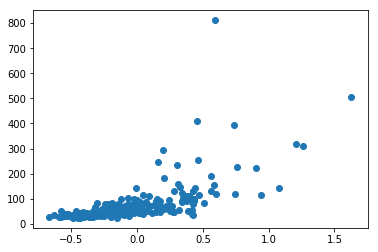

In [14]:
plt.scatter(x=summary_df['price'], y=summary_df['avg_agi'])

In [15]:
df = data.copy()
df.drop(['alias', 'city', 'id'], axis=1, inplace=True)

In [16]:
df['zip_code'] = df['zip_code'].astype(str)

In [17]:
df = df.dropna(axis=0, how='any')

In [25]:
df[df['zip_code'] == '90021']

,categories,latitude,longitude,price,rating,review_count,zip_code,avg_agi
11778,"['mexican', 'bars']",34.039080,-118.240428,2,4.0,1082.0,90021,73.61
11779,['japanese'],34.028189,-118.239372,1,2.0,31.0,90021,73.61
11780,['icecream'],34.031520,-118.236490,2,4.5,42.0,90021,73.61
11781,"['grocery', 'breakfast_brunch', 'markets']",34.036139,-118.231635,2,4.0,335.0,90021,73.61
11782,"['bbq', 'foodstands', 'sandwiches']",34.031520,-118.236490,2,4.5,62.0,90021,73.61
...,...,...,...,...,...,...,...,...
11872,['persian'],34.026611,-118.242798,1,4.0,59.0,90021,73.61
11873,"['italian', 'seafood', 'supperclubs']",34.031496,-118.238998,3,4.0,65.0,90021,73.61
11874,"['mexican', 'foodtrucks']",34.031748,-118.231928,1,4.5,39.0,90021,73.61
11875,"['convenience', 'coffee']",34.026867,-118.238764,1,2.5,12.0,90021,73.61


# use scipy cKDTree to calculate nearest neighbor distances

In [19]:
# https://stackoverflow.com/questions/12923586/
# https://stackoverflow.com/questions/36798782/

coords = df.copy()
coords = coords[['latitude', 'longitude']]

In [20]:
temp_point = list(coords.iloc[4])

In [21]:
# making the tree

distance_tree = cKDTree(coords)

In [22]:
# returns six closest points, including itself
# first array shows distances
# second array appears to show which indices are closest?

_, idx = distance_tree.query(temp_point, k=20)
for i in idx:
    print(data.iloc[i])

alias           yuk-dae-jang-san-gabriel-2
categories                      ['korean']
city                           San Gabriel
id                  DwvljRkxkMEljQBYX-MeTw
latitude                           34.1021
longitude                          -118.11
price                                    2
rating                                 4.5
review_count                           158
zip_code                             91776
avg_agi                             37.211
Name: 4, dtype: object
alias           half-and-half-good-old-time-san-gabriel
categories                   ['taiwanese', 'bubbletea']
city                                        San Gabriel
id                               QhhWJVDP4L805y_YgwM3BQ
latitude                                        34.1021
longitude                                       -118.11
price                                                 1
rating                                                4
review_count                                        209


In [23]:
coords[KDTree(coords).query(list(coords.iloc[0]))[1]]

KeyError: 0

# use CountVectorizer

In [ ]:
X = df[['categories', 'price', 'rating', 'review_count', 'zip_code']]
y = df['avg_agi']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=111)

In [ ]:
cvect = CountVectorizer()

In [ ]:
V_train = cvect.fit_transform(X_train['categories'])

In [ ]:
categories = list(cvect.get_feature_names())

In [ ]:
categories

In [ ]:
V_df = pd.DataFrame(data=V_train.toarray(), columns=categories)

In [ ]:
V_df.shape

In [ ]:
X_train.shape

In [ ]:
X_train = X_train.join(V_df)

In [ ]:
X_train[X_train['zip_code'] == '90001']

In [ ]:
# https://stackoverflow.com/questions/42935334/

X_train.iloc[:, 5:-1] = X_train.iloc[:, 5:-1].mul(X_train.iloc[:, 1], axis=0)

In [ ]:
X_train_nan = X_train.replace(0, np.NaN)

In [ ]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

In [ ]:
X_train_nan.describe().T[X_train_nan.describe().T['count'] > 200].sort_values(by='count', ascending=False)

In [ ]:
X_train_nan.describe().T[X_train_nan.describe().T['count'] > 200].sort_values(by='mean', ascending=False)

In [ ]:
X_train_nan[X_train_nan['zip_code'] == '90001'].describe().T.sort_values(by='mean', ascending=False)

In [ ]:
X_train[X_train['zip_code'] == '90001']

In [ ]:
def numeric_filter(df):
    features = ['price', 'rating', 'review_count']
    return df[features]

Numeric = FunctionTransformer(numeric_filter, validate=False)

In [ ]:
def category_filter(df):
    return df['categories']

Categories = FunctionTransformer(category_filter, validate=False)

In [ ]:
numeric_transformer = Pipeline([
    ('num_filt', Numeric),
    ('poly', PolynomialFeatures()),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline([
    ('cat_filt', Categories),
    ('cvect', CountVectorizer())
])

In [ ]:
pipe = Pipeline([
    ('union', FeatureUnion([
        ('num', numeric_transformer),
        ('cat', categorical_transformer)
    ])),
    ('rfr', RandomForestRegressor(n_estimators=10,
                                  verbose=1))
])

In [ ]:
pipe.fit_transform(X_train, y_train)

In [ ]:
print(pipe.score(X_train, y_train))
print(pipe.score(X_test, y_test))

In [ ]:
list(pipe.named_steps['rfr'].feature_importances_)

In [ ]:
pipe.named_steps['union'].get_feature_names()

In [ ]:
sns.heatmap(df.corr(),
           annot = True,
           cmap = 'coolwarm')

In [ ]:
plt.figure(figsize=(21, 15))
plt.scatter(df['longitude'], df['latitude'], s=2, alpha=0.2)

# KMeans Clustering

In [ ]:
df._get_numeric_data()

In [ ]:
# Try to pick interesting columns for clustering

sns.pairplot(df._get_numeric_data())

In [ ]:
# Function to create KMeans Clustering for 2 features from original dataframe

def kmean(var1, var2):
    features = [var1, var2]
    X = df[features]

    sc = StandardScaler()
    X = sc.fit_transform(X)

    km = KMeans(n_clusters=3,
           random_state=42)
    km.fit(X)

    df_copy = df.copy()
    df_copy['cluster'] = km.labels_

    print(f' Cluster Centers: \n{km.cluster_centers_}')

    centroids = pd.DataFrame(
        sc.inverse_transform(km.cluster_centers_),
        columns = features
    )

    print(f' Centroids for Plot: \n{centroids}')


    # Visualizing Clusters
    plt.figure(figsize=(7,7));

    ## Plot scatter by cluster / color, and centroids
    colors = ["red", "green", "blue"]
    df_copy['color'] = df_copy['cluster'].map(lambda p: colors[p])

    ax = df.plot(    
        kind="scatter", 
        x=var1, y=var2,
        figsize=(10,8),
        c = df_copy['color']
    )

    centroids.plot(
        kind="scatter", 
        x=var1, y=var2, 
        marker="*", c=["r", "g", "b"], s=550,
        ax=ax
    );

In [ ]:
kmean('latitude', 'longitude')

In [ ]:
kmean('longitude', 'zip_code')

In [ ]:
kmean('latitude', 'zip_code')

# Linear Regression Model
- Only price, rating, dummied zip_code as features.
- Target: ave_agi

In [ ]:
df['zip_code'] = df['zip_code'].astype(int).astype(str)

In [ ]:
df_dummied_city = pd.get_dummies(data=df,columns=['zip_code'])

In [ ]:
df_dummied_city._get_numeric_data().head(2)

In [ ]:
features = df_dummied_city._get_numeric_data().drop(columns=['ave_agi', 'review_count', 'latitude', 'longitude', 'price*rating'])

X = features
y = df_dummied_city['ave_agi']


X_train, X_test, y_train, y_test = train_test_split(X,y,
                                                   random_state = 42)

sc = StandardScaler()

X_train = sc.fit_transform(X_train)
x_test = sc.transform(X_test)

In [ ]:
lr = LinearRegression()
lr.fit(X_train, y_train)

In [ ]:
lr.score(X_train, y_train)

In [ ]:
lr.score(X_test, y_test)

In [ ]:
cross_val_score(lr, X_train, y_train, cv = 5).mean()

# Linear Regression Model
- This was really really really bad - Aerika

In [ ]:
df_dummied_city = pd.get_dummies(data=df,columns=['city'])

In [ ]:
df_dummied_city.head(2)

In [ ]:
features = df_dummied_city._get_numeric_data().drop(columns=['ave_agi'])

X = features
y = df_dummied_city['ave_agi']


X_train, X_test, y_train, y_test = train_test_split(X,y,
                                                   random_state = 42)

sc = StandardScaler()

X_train = sc.fit_transform(X_train)
x_test = sc.transform(X_test)

In [ ]:
lr = LinearRegression()
lr.fit(X_train, y_train)

In [ ]:
lr.score(X_train, y_train)

In [ ]:
lr.score(X_test, y_test)

In [ ]:
cross_val_score(lr, X_train, y_train, cv = 5).mean()

Jerry's code from previous project, trying to use it to perform a bunch of different models for this project  
Still need to tweak functions so they can be used for this project.

In [ ]:
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer
from sklearn.preprocessing import StandardScaler, PowerTransformer, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [ ]:
# numeric columns that seem like continuous features.
numeric_features = ['price', 'rating', 'review_count', 'ave_agi']

# columns that should get dummied out
categorical_features = ['zip_code']

In [ ]:
# transforms numeric columns
# just comment out whichever transformers you want to leave out

numeric_transformer = Pipeline([
    ('poly', PolynomialFeatures(include_bias=False, 
                                interaction_only=False)),
    ('power', PowerTransformer()),
#     ('imputer', SimpleImputer(strategy=)),
    ('scaler', StandardScaler())
])

In [ ]:
# transforms categorical columns into dummy columns

categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='unknown')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

In [ ]:
filter_transformer = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

In [ ]:
# put alias as keys to dictionary
# put instantiation of model, including parameters you don't want to gridsearch, as value

est_dict = {
    'logreg': LogisticRegression(solver='lbfgs'),
    'knn': KNeighborsClassifier(),
    'rand': RandomForestClassifier(n_estimators=100, random_state=111),
    'extra': ExtraTreesClassifier(n_estimators=100, random_state=111),
    'ada': AdaBoostClassifier(base_estimator=DecisionTreeClassifier(), random_state=111)
}

# list of aliases so we can loop through models
estimators = ['logreg', 'knn', 'rand', 'extra', 'ada']

In [ ]:
'''
to access parameters, follow this format:

grid_params = {'filter__num__poly__param': [],
    'estimatoralias__param': []
    }
'''

pipe = Pipeline([
    ('filter', filter_transformer),
    ('estimator', Estimator())
])

## Adjusted price

Different types of businesses will have a different distribution of price ranges depending on the product or service they provide. For example, a taco shop with a price rating of '$$' is actually relatively expensive, whereas a sushi restaurant with the same rating is quite common. We hypothesize that a neighborhood with expensive taco shops might be more affluent than a neighborhood with average-priced sushi restaurants; more generally, neighborhoods with disproportionately expensive businessess might be more wealthy than those with just objectively expensive businesses.

In [15]:
print(master_df[master_df['category'].str.contains('tacos')]['price'].mean())
print(master_df[master_df['category'].str.contains('sushi')]['price'].mean())

NameError: name 'master_df' is not defined

In [ ]:
# master_df[master_df['price'] == 4]['category'].value_counts(normalize=True)[:10]

We introduce the idea of an adjusted price, which has the goal of scaling a listing's price relative to the overall expensiveness of its parent category. We will calculate the adjusted price by looking at businesses category-by-category and standard scaling the listed price to the mean of that category.

Since we do not want to have any data leakage, we can only apply this transformation on our training data set. Therefore, it is inappropriate to engineer this feature at this stage.

In [ ]:
class StandardScaler(BaseEstimator, TransformerMixin):
    """Standardize features by removing the mean and scaling to unit variance
    The standard score of a sample `x` is calculated as:
        z = (x - u) / s
    where `u` is the mean of the training samples or zero if `with_mean=False`,
    and `s` is the standard deviation of the training samples or one if
    `with_std=False`.
    Centering and scaling happen independently on each feature by computing
    the relevant statistics on the samples in the training set. Mean and
    standard deviation are then stored to be used on later data using the
    `transform` method.
    Standardization of a dataset is a common requirement for many
    machine learning estimators: they might behave badly if the
    individual features do not more or less look like standard normally
    distributed data (e.g. Gaussian with 0 mean and unit variance).
    For instance many elements used in the objective function of
    a learning algorithm (such as the RBF kernel of Support Vector
    Machines or the L1 and L2 regularizers of linear models) assume that
    all features are centered around 0 and have variance in the same
    order. If a feature has a variance that is orders of magnitude larger
    that others, it might dominate the objective function and make the
    estimator unable to learn from other features correctly as expected.
    This scaler can also be applied to sparse CSR or CSC matrices by passing
    `with_mean=False` to avoid breaking the sparsity structure of the data.
    Read more in the :ref:`User Guide <preprocessing_scaler>`.
    Parameters
    ----------
    copy : boolean, optional, default True
        If False, try to avoid a copy and do inplace scaling instead.
        This is not guaranteed to always work inplace; e.g. if the data is
        not a NumPy array or scipy.sparse CSR matrix, a copy may still be
        returned.
    with_mean : boolean, True by default
        If True, center the data before scaling.
        This does not work (and will raise an exception) when attempted on
        sparse matrices, because centering them entails building a dense
        matrix which in common use cases is likely to be too large to fit in
        memory.
    with_std : boolean, True by default
        If True, scale the data to unit variance (or equivalently,
        unit standard deviation).
    Attributes
    ----------
    scale_ : ndarray or None, shape (n_features,)
        Per feature relative scaling of the data. This is calculated using
        `np.sqrt(var_)`. Equal to ``None`` when ``with_std=False``.
        .. versionadded:: 0.17
           *scale_*
    mean_ : ndarray or None, shape (n_features,)
        The mean value for each feature in the training set.
        Equal to ``None`` when ``with_mean=False``.
    var_ : ndarray or None, shape (n_features,)
        The variance for each feature in the training set. Used to compute
        `scale_`. Equal to ``None`` when ``with_std=False``.
    n_samples_seen_ : int or array, shape (n_features,)
        The number of samples processed by the estimator for each feature.
        If there are not missing samples, the ``n_samples_seen`` will be an
        integer, otherwise it will be an array.
        Will be reset on new calls to fit, but increments across
        ``partial_fit`` calls.
    Examples
    --------
    >>> from sklearn.preprocessing import StandardScaler
    >>> data = [[0, 0], [0, 0], [1, 1], [1, 1]]
    >>> scaler = StandardScaler()
    >>> print(scaler.fit(data))
    StandardScaler(copy=True, with_mean=True, with_std=True)
    >>> print(scaler.mean_)
    [0.5 0.5]
    >>> print(scaler.transform(data))
    [[-1. -1.]
     [-1. -1.]
     [ 1.  1.]
     [ 1.  1.]]
    >>> print(scaler.transform([[2, 2]]))
    [[3. 3.]]
    See also
    --------
    scale: Equivalent function without the estimator API.
    :class:`sklearn.decomposition.PCA`
        Further removes the linear correlation across features with 'whiten=True'.
    Notes
    -----
    NaNs are treated as missing values: disregarded in fit, and maintained in
    transform.
    We use a biased estimator for the standard deviation, equivalent to
    `numpy.std(x, ddof=0)`. Note that the choice of `ddof` is unlikely to
    affect model performance.
    For a comparison of the different scalers, transformers, and normalizers,
    see :ref:`examples/preprocessing/plot_all_scaling.py
    <sphx_glr_auto_examples_preprocessing_plot_all_scaling.py>`.
    """  # noqa

    def __init__(self, copy=True, with_mean=True, with_std=True):
        self.with_mean = with_mean
        self.with_std = with_std
        self.copy = copy

    def _reset(self):
        """Reset internal data-dependent state of the scaler, if necessary.
        __init__ parameters are not touched.
        """

        # Checking one attribute is enough, becase they are all set together
        # in partial_fit
        if hasattr(self, 'scale_'):
            del self.scale_
            del self.n_samples_seen_
            del self.mean_
            del self.var_

    def fit(self, X, y=None):
        """Compute the mean and std to be used for later scaling.
        Parameters
        ----------
        X : {array-like, sparse matrix}, shape [n_samples, n_features]
            The data used to compute the mean and standard deviation
            used for later scaling along the features axis.
        y
            Ignored
        """

        # Reset internal state before fitting
        self._reset()
        return self.partial_fit(X, y)

    def partial_fit(self, X, y=None):
        """Online computation of mean and std on X for later scaling.
        All of X is processed as a single batch. This is intended for cases
        when `fit` is not feasible due to very large number of `n_samples`
        or because X is read from a continuous stream.
        The algorithm for incremental mean and std is given in Equation 1.5a,b
        in Chan, Tony F., Gene H. Golub, and Randall J. LeVeque. "Algorithms
        for computing the sample variance: Analysis and recommendations."
        The American Statistician 37.3 (1983): 242-247:
        Parameters
        ----------
        X : {array-like, sparse matrix}, shape [n_samples, n_features]
            The data used to compute the mean and standard deviation
            used for later scaling along the features axis.
        y
            Ignored
        """
        X = check_array(X, accept_sparse=('csr', 'csc'), copy=self.copy,
                        estimator=self, dtype=FLOAT_DTYPES,
                        force_all_finite='allow-nan')

        # Even in the case of `with_mean=False`, we update the mean anyway
        # This is needed for the incremental computation of the var
        # See incr_mean_variance_axis and _incremental_mean_variance_axis

        # if n_samples_seen_ is an integer (i.e. no missing values), we need to
        # transform it to a NumPy array of shape (n_features,) required by
        # incr_mean_variance_axis and _incremental_variance_axis
        if (hasattr(self, 'n_samples_seen_') and
                isinstance(self.n_samples_seen_, (int, np.integer))):
            self.n_samples_seen_ = np.repeat(
                self.n_samples_seen_, X.shape[1]).astype(np.int64, copy=False)

        if sparse.issparse(X):
            if self.with_mean:
                raise ValueError(
                    "Cannot center sparse matrices: pass `with_mean=False` "
                    "instead. See docstring for motivation and alternatives.")

            sparse_constructor = (sparse.csr_matrix
                                  if X.format == 'csr' else sparse.csc_matrix)
            counts_nan = sparse_constructor(
                        (np.isnan(X.data), X.indices, X.indptr),
                        shape=X.shape).sum(axis=0).A.ravel()

            if not hasattr(self, 'n_samples_seen_'):
                self.n_samples_seen_ = (
                        X.shape[0] - counts_nan).astype(np.int64, copy=False)

            if self.with_std:
                # First pass
                if not hasattr(self, 'scale_'):
                    self.mean_, self.var_ = mean_variance_axis(X, axis=0)
                # Next passes
                else:
                    self.mean_, self.var_, self.n_samples_seen_ = \
                        incr_mean_variance_axis(X, axis=0,
                                                last_mean=self.mean_,
                                                last_var=self.var_,
                                                last_n=self.n_samples_seen_)
            else:
                self.mean_ = None
                self.var_ = None
                if hasattr(self, 'scale_'):
                    self.n_samples_seen_ += X.shape[0] - counts_nan
        else:
            if not hasattr(self, 'n_samples_seen_'):
                self.n_samples_seen_ = np.zeros(X.shape[1], dtype=np.int64)

            # First pass
            if not hasattr(self, 'scale_'):
                self.mean_ = .0
                if self.with_std:
                    self.var_ = .0
                else:
                    self.var_ = None

            if not self.with_mean and not self.with_std:
                self.mean_ = None
                self.var_ = None
                self.n_samples_seen_ += X.shape[0] - np.isnan(X).sum(axis=0)
            else:
                self.mean_, self.var_, self.n_samples_seen_ = \
                    _incremental_mean_and_var(X, self.mean_, self.var_,
                                              self.n_samples_seen_)

        # for backward-compatibility, reduce n_samples_seen_ to an integer
        # if the number of samples is the same for each feature (i.e. no
        # missing values)
        if np.ptp(self.n_samples_seen_) == 0:
            self.n_samples_seen_ = self.n_samples_seen_[0]

        if self.with_std:
            self.scale_ = _handle_zeros_in_scale(np.sqrt(self.var_))
        else:
            self.scale_ = None

        return self

    def transform(self, X, copy=None):
        """Perform standardization by centering and scaling
        Parameters
        ----------
        X : array-like, shape [n_samples, n_features]
            The data used to scale along the features axis.
        copy : bool, optional (default: None)
            Copy the input X or not.
        """
        check_is_fitted(self, 'scale_')

        copy = copy if copy is not None else self.copy
        X = check_array(X, accept_sparse='csr', copy=copy,
                        estimator=self, dtype=FLOAT_DTYPES,
                        force_all_finite='allow-nan')

        if sparse.issparse(X):
            if self.with_mean:
                raise ValueError(
                    "Cannot center sparse matrices: pass `with_mean=False` "
                    "instead. See docstring for motivation and alternatives.")
            if self.scale_ is not None:
                inplace_column_scale(X, 1 / self.scale_)
        else:
            if self.with_mean:
                X -= self.mean_
            if self.with_std:
                X /= self.scale_
        return X

    def inverse_transform(self, X, copy=None):
        """Scale back the data to the original representation
        Parameters
        ----------
        X : array-like, shape [n_samples, n_features]
            The data used to scale along the features axis.
        copy : bool, optional (default: None)
            Copy the input X or not.
        Returns
        -------
        X_tr : array-like, shape [n_samples, n_features]
            Transformed array.
        """
        check_is_fitted(self, 'scale_')

        copy = copy if copy is not None else self.copy
        if sparse.issparse(X):
            if self.with_mean:
                raise ValueError(
                    "Cannot uncenter sparse matrices: pass `with_mean=False` "
                    "instead See docstring for motivation and alternatives.")
            if not sparse.isspmatrix_csr(X):
                X = X.tocsr()
                copy = False
            if copy:
                X = X.copy()
            if self.scale_ is not None:
                inplace_column_scale(X, self.scale_)
        else:
            X = np.asarray(X)
            if copy:
                X = X.copy()
            if self.with_std:
                X *= self.scale_
            if self.with_mean:
                X += self.mean_
        return X

    def _more_tags(self):
        return {'allow_nan': True}